In [ ]:
!pip install cirq --pre

In [2]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import recirq.mbl_dtc as dtc_utils

In [3]:
# define the qubits we'll be using
qubit_locations = [(3, 9), (3, 8), (3, 7), (4, 7), (4, 8), (5, 8), (5, 7), (5, 6), (6, 6), (6, 5), (7, 5), (8, 5),
              (8, 4), (8, 3), (7, 3), (6, 3)]

qubits = [cirq.GridQubit(*idx) for idx in qubit_locations]
num_qubits = len(qubits)

# prepare our DTC circuit list, with 0 through 100 cycles
num_cycles = 100
circuit_list = dtc_utils.symbolic_dtc_circuit_list(qubits=qubits, cycles=num_cycles)

<timed exec>:71: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


CPU times: user 8min 23s, sys: 8.65 s, total: 8min 31s
Wall time: 8min 32s


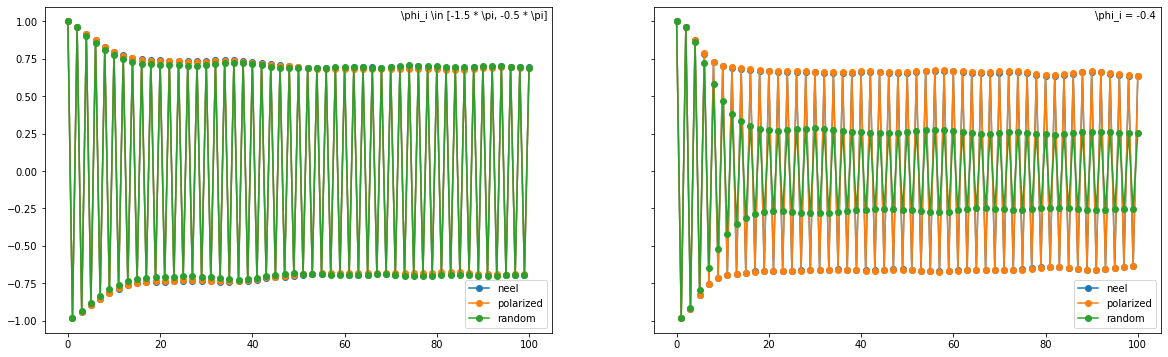

In [4]:
%%time
# Figure 3a

# number of instances and thermalization (g) constants
instances = 24
g = 0.94

# random noise (h)
local_fields = np.random.uniform(-1.0, 1.0, (instances, num_qubits))

# prepare random and fixed phis to compare
disordered_phis = np.random.uniform(-1.5*np.pi, -0.5*np.pi, (instances, num_qubits))
fixed_phi = -0.4

# use thermalization (g) for all instances
gs = np.full(instances, g)

# parameters for two-qubit FSim gates
# zeros for theta, zeta, chi
thetas = np.zeros((instances, num_qubits))
zetas = np.zeros((instances, num_qubits))
chis = np.zeros((instances, num_qubits))

# expand fixed phis for all instances and qubits
fixed_phis = np.full((instances, num_qubits), fixed_phi)

# prepare 3 initial states to compare
neel_initial_state = np.tile([0,1], num_qubits//2)
polarized_initial_state = np.full(num_qubits, 0)
random_initial_state = [0,0,1,1,1,0,0,0,0,1,0,0,1,1,0,0,1,1,1,1][:num_qubits]
initial_state_dict = {'neel':neel_initial_state, 'polarized':polarized_initial_state, 'random':random_initial_state}

# prepare subplot axes
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20, 6))

for random_phi, axis in zip([True, False], axes): 
    # use either random, disordered phis or fixed ones
    if random_phi: 
        phis = disordered_phis
    else: 
        phis = fixed_phis
    # gamma dependent on phis
    gammas = -1/2*phis

    # evaluate and yield probabilities and their initial states, for each initial state option
    for initial_state_label, initial_state in initial_state_dict.items(): 
        # expand initial state for all disorder instances
        initial_state_array = np.asarray([initial_state] * instances)

        # prepare parameter resolvers
        param_resolvers = dtc_utils.dtc_param_resolver_sweep(gs, initial_state_array, local_fields, thetas, zetas, chis, gammas, phis)

        # simulate and collect probabilities
        probabilities = np.asarray(list(dtc_utils.simulate_dtc_circuit_list_sweep(circuit_list, param_resolvers, qubits)))

        # turn probabilities into polarizations, relative to initial_state
        polarizations = dtc_utils.get_polarizations(probabilities, num_qubits, cycles_axis=1, probabilities_axis=2, initial_states=initial_state_array)

        # average over both instances and qubit sites, leaving only cycles
        average_polarizations = np.mean(polarizations, axis=(0,2))

        # plot and label
        axis.plot(average_polarizations, marker='o', label=initial_state_label)

# set phi labels
phi_labels = ['\phi_i \in [-1.5 * \pi, -0.5 * \pi]', '\phi_i = -0.4']

# add phi labels and legend to each subplot
for phi_label, axis in zip(phi_labels, axes): 
    axis.text(0.99, 0.99, phi_label, horizontalalignment='right', verticalalignment='top', transform=axis.transAxes)
    axis.legend(loc='lower right')
fig.show()
